In [112]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Activation, Dense, Flatten, Conv1D, Add, BatchNormalization,LayerNormalization
from tensorflow.keras.layers import Dropout,MaxPooling1D,Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import DepthwiseConv2D, Multiply
from efficientnet.tfkeras import EfficientNetB0
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.initializers import he_normal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd #csv
from sklearn.model_selection import train_test_split #June 6, 2024
from tensorflow.keras.utils import to_categorical #June 6, 2024
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
#from tqdm.auto import tqdm #progress bar
from scipy.io import loadmat
import os # path issues

In [ ]:
data_path = r"C:\PQD_with noise" 
snr_levels = ["50dB", "40dB", "30dB", "20dB"]
#snr_levels = ["40dB"]
 
disturbance_labels = {
    'Normal': [0, 0, 0, 0, 0, 0],
    'Flicker': [1, 0, 0, 0, 0, 0],
    'Swell': [0, 1, 0, 0, 0, 0],
    'Sag': [0, 0, 1, 0, 0, 0],
    'Interruption': [0, 0, 0, 1, 0, 0],
    'Harmonics': [0, 0, 0, 0, 1, 0],
    'Oscillatory transient': [0, 0, 0, 0, 0, 1],
    'Flicker+Swell': [1, 1, 0, 0, 0, 0],
    'Flicker+Sag': [1, 0, 1, 0, 0, 0],
    'Flicker+Harmonics': [1, 0, 0, 0, 1, 0],
    'Flicker+Transient': [1, 0, 0, 0, 0, 1],
    'Swell+Harmonics': [0, 1, 0, 0, 1, 0],
    'Swell+Transient': [0, 1, 0, 0, 0, 1],
    'Sag+Harmonics': [0, 0, 1, 0, 1, 0],
    'Sag+Transient': [0, 0, 1, 0, 0, 1],
    'Interruption+Harmonics': [0, 0, 0, 1, 1, 0],
    'Flicker+Swell+Harmonics': [1, 1, 0, 0, 1, 0],
    'Flicker+Sag+Harmonics': [1, 0, 1, 0, 1, 0],
    'Swell+Harmonics+Transient': [0, 1, 0, 0, 1, 1],
    'Sag+Harmonics+Transient': [0, 0, 1, 0, 1, 1]
}

In [71]:
# Function to load data
def load_data():
    X = []
    y = []
    for snr in snr_levels:
        folder_path = os.path.join(data_path, snr)
        for file in os.listdir(folder_path):
            if file.endswith('.xlsx'):
                file_path = os.path.join(folder_path, file)
                df = pd.read_excel(file_path, header=None,engine='openpyxl')
                df = df.iloc[:500, :]  # Select only the first 600 rows #Jun 8, to be changed to 600
                X.append(df.values)
                label_name = os.path.splitext(file)[0]
                y.append(disturbance_labels[label_name])
    X = np.concatenate(X, axis=0)
    y = np.repeat(y, 500, axis=0) # Repeat each label 600 times
    return X, y
 
X, y = load_data()
X = X.reshape(-1, 640, 1)  # Reshape for CNN input
 
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [119]:
#X = X.reshape(-1, 640, 1)  # Reshape for CNN input
print(y_test[0:5])
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
#X_train.shape
#y_train.shape

[[0 0 1 0 1 1]
 [0 1 0 0 0 1]
 [1 0 1 0 0 0]
 [0 0 1 0 1 0]
 [0 1 0 0 1 1]]
X_train shape: (24000, 640, 1)
X_val shape: (8000, 640, 1)
X_test shape: (8000, 640, 1)


In [207]:
from tensorflow.keras.layers import SeparableConv1D 

def depthwise_block(x, filters, strides):
    x = SeparableConv1D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size=1, padding='same', activation='relu',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def mobile_net(input_shape, num_classes=6):
    input_tensor = Input(shape=input_shape)
    
    # Initial Convolution
    x = Conv1D(64, kernel_size=7, strides=2, padding='same',kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Depthwise Separable Convolution Blocks
    x = depthwise_block(x, filters=64, strides=1)
    x = depthwise_block(x, filters=128, strides=2)
    x = depthwise_block(x, filters=128, strides=1)
    x = depthwise_block(x, filters=256, strides=2)
    x = depthwise_block(x, filters=256, strides=1)
    x = depthwise_block(x, filters=512, strides=2)
    
    # Global Average Pooling and Dense Output Layer
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='sigmoid',kernel_initializer='he_normal')(x)
    
    model = Model(inputs=input_tensor, outputs=x)
    
    return model

In [208]:
input_shape = (640, 1)
model = mobile_net(input_shape)
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 640, 1)]          0         
_________________________________________________________________
conv1d_363 (Conv1D)          (None, 320, 64)           512       
_________________________________________________________________
batch_normalization_329 (Bat (None, 320, 64)           256       
_________________________________________________________________
activation_225 (Activation)  (None, 320, 64)           0         
_________________________________________________________________
separable_conv1d_69 (Separab (None, 320, 64)           4352      
_________________________________________________________________
batch_normalization_330 (Bat (None, 320, 64)           256       
_________________________________________________________________
activation_226 (Activation)  (None, 320, 64)           0  

In [209]:
# Compile the model
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=200, decay_rate=0.6, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [210]:
history = model.fit(X_train, y_train, epochs=20, batch_size=120, validation_data=(X_val, y_val))

Train on 24000 samples, validate on 8000 samples
Epoch 1/20
24000/24000 [==============================] - 210s 9ms/sample - loss: 0.1623 - accuracy: 0.9360 - val_loss: 0.6646 - val_accuracy: 0.6996
Epoch 2/20
24000/24000 [==============================] - 181s 8ms/sample - loss: 0.0715 - accuracy: 0.9768 - val_loss: 0.9341 - val_accuracy: 0.6591
Epoch 3/20
24000/24000 [==============================] - 177s 7ms/sample - loss: 0.0533 - accuracy: 0.9833 - val_loss: 0.7750 - val_accuracy: 0.8042
Epoch 4/20
24000/24000 [==============================] - 178s 7ms/sample - loss: 0.0424 - accuracy: 0.9868 - val_loss: 0.0497 - val_accuracy: 0.9834
Epoch 5/20
24000/24000 [==============================] - 178s 7ms/sample - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.0390 - val_accuracy: 0.9871
Epoch 6/20
24000/24000 [==============================] - 180s 8ms/sample - loss: 0.0328 - accuracy: 0.9902 - val_loss: 0.0359 - val_accuracy: 0.9882
Epoch 7/20
24000/24000 [===========================

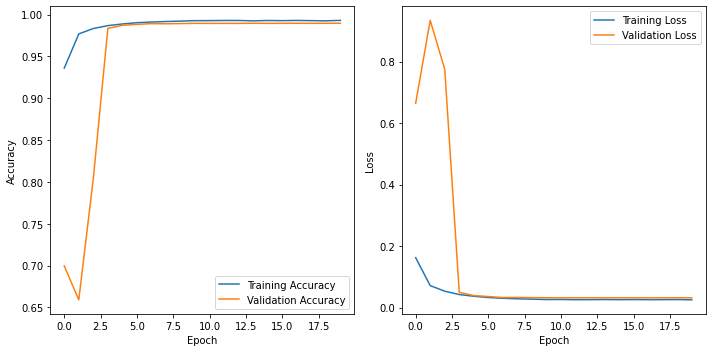

In [211]:
plt.figure(figsize=(10, 5))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
 
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 
plt.tight_layout()
plt.show()

In [213]:
#save the model
import os.path
if os.path.isfile('Models/MobileNet.h5') is False:
    model.save('Models/MobileNet.h5')

In [212]:
from sklearn.metrics import classification_report, accuracy_score
import time

# Function to load data for a specific SNR level
def load_data_for_snr(snr, limit_rows=100):
    X = []
    y = []
    folder_path = os.path.join(data_path, snr)
    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_excel(file_path, header=None, engine='openpyxl')
            df = df.iloc[-limit_rows:, :]  # Select only the last 100 rows
            X.append(df.values)
            label_name = os.path.splitext(file)[0]
            y.append(disturbance_labels[label_name])
    X = np.concatenate(X, axis=0)
    y = np.repeat(y, limit_rows, axis=0)  # Repeat each label `limit_rows` times
    X = X.reshape(-1, 640, 1)  # Reshape for 1D CNN input
    return X, y

# Function to evaluate model on different SNR levels
def evaluate_on_snr_levels(model, snr_levels):
    for snr in snr_levels:
        X, y = load_data_for_snr(snr)
        start_time = time.time()
        y_pred = model.predict(X)
        end_time = time.time()
        sample_time = (end_time - start_time) / len(X)  # Calculate time per sample
        y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
        accuracy = accuracy_score(y, y_pred)
        report = classification_report(y, y_pred, target_names=['Flicker', 'Swell', 'Sag', 'Interruption', 'Harmonics', 'Oscillatory transient'], zero_division=1)
       # report = classification_report(y, y_pred, target_names=list(disturbance_labels.keys()))
        print(f'SNR: {snr} - Accuracy: {accuracy}')
        print(f'Average Time per Sample for SNR {snr}: {sample_time:.6f} seconds')
        print(f'Classification Report for SNR {snr}:\n{report}')
        
# Evaluate the model on test data from different SNR levels
evaluate_on_snr_levels(model, snr_levels)

SNR: 50dB - Accuracy: 0.9475
Average Time per Sample for SNR 50dB: 0.001352 seconds
Classification Report for SNR 50dB:
                       precision    recall  f1-score   support

              Flicker       1.00      1.00      1.00       700
                Swell       1.00      0.98      0.99       600
                  Sag       1.00      0.99      0.99       600
         Interruption       1.00      1.00      1.00       200
            Harmonics       1.00      1.00      1.00       900
Oscillatory transient       0.99      0.86      0.92       600

            micro avg       1.00      0.97      0.99      3600
            macro avg       1.00      0.97      0.98      3600
         weighted avg       1.00      0.97      0.98      3600
          samples avg       1.00      0.98      0.98      3600

SNR: 40dB - Accuracy: 0.953
Average Time per Sample for SNR 40dB: 0.001054 seconds
Classification Report for SNR 40dB:
                       precision    recall  f1-score   support

 